In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *
from clustering.utils import *

# Load Observations

In [4]:
dt_format = '%Y-%m-%d'
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave
train_test_split_time= '2020-12-01'
len_test_period = (pd.to_datetime(end_time, format=dt_format) - pd.to_datetime(train_test_split_time, format=dt_format)).days

df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
df_obs.drop(columns=['number_of_deaths', 'newly_infected'], inplace=True)
df_obs.rename(columns={'Date':'date', 'hospitalization': 'observed'}, inplace=True)
df_obs.head(3)

,date,observed
0,2020-08-01,3.5
1,2020-08-02,3.0
2,2020-08-03,4.5


# Load Experiment Results

In [5]:
split=False
df_comparison = df_obs.copy()
path_results = 'data/modeling/results/all_data/'
if split:
  path_results = 'data/modeling/results/split/'
list_files = os.listdir(path_results)
list_col_names = []
for f in list_files:
  col_name = f[26:46]
  list_col_names.append(col_name)
  df_temp = pd.read_csv(path_results+f)
  df_comparison[col_name] = df_temp['expected_hospitalisation']
df_comparison

,date,observed,nn_group_data_1_.csv,linear_group_data_1_,linear_factor_data_5,nn_factor_data_5_F0c,linear_factor_data_1,nn_factor_data_1_F3b
0,2020-08-01,3.5,2.500000e-14,2.500000e-14,2.500000e-14,2.500000e-14,2.500000e-14,2.500000e-14
1,2020-08-02,3.0,5.760071e-02,5.818801e-02,5.817557e-02,5.819327e-02,5.817313e-02,1.184486e-02
2,2020-08-03,4.5,1.732903e-01,1.750572e-01,1.750198e-01,1.750730e-01,1.750124e-01,3.563496e-02
3,2020-08-04,6.0,3.728272e-01,3.766286e-01,3.765481e-01,3.766626e-01,3.765323e-01,7.666720e-02
4,2020-08-05,6.0,5.958790e-01,6.019547e-01,6.018260e-01,6.020091e-01,6.018007e-01,1.225350e-01
...,...,...,...,...,...,...,...,...
179,2021-01-27,54.0,5.799395e+01,6.547154e+01,6.391256e+01,6.458298e+01,9.871183e+01,6.105141e+01
180,2021-01-28,54.5,5.486670e+01,6.303733e+01,6.163600e+01,6.229577e+01,9.826006e+01,5.843220e+01
181,2021-01-29,49.5,5.203663e+01,6.077313e+01,5.937649e+01,6.005725e+01,9.781754e+01,5.593560e+01
182,2021-01-30,38.5,4.932443e+01,5.857600e+01,5.716933e+01,5.786917e+01,9.739852e+01,5.357669e+01


# Calculate Metrics

In [6]:
def calc_mse(observed, expected):
  diff = expected - observed
  square = np.square(diff)
  msr = square.mean()
  return msr

In [7]:
list_mse = []
for col in list_col_names:
  mse_temp = calc_mse(df_comparison['observed'].to_numpy(), df_comparison[col].to_numpy())
  if split:
    mse_temp = calc_mse(df_comparison['observed'].iloc[-len_test_period:].to_numpy(), df_comparison[col].iloc[-len_test_period:].to_numpy())
  list_mse.append(mse_temp)
list_mse

[134.7294529608251,
 157.86982577372592,
 159.39085758537686,
 158.27643192779868,
 529.8476728818933,
 122.59260513543327]

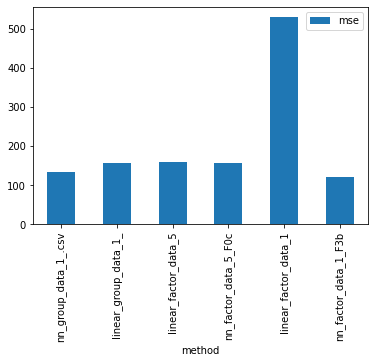

In [8]:
df_metrics = pd.DataFrame()
df_metrics['method'] = list_col_names
df_metrics['mse'] = list_mse
df_metrics.plot.bar(x='method')

# Visual Comparison of Hospitalizations

In [9]:
df_comparison_long = pd.melt(df_comparison, id_vars=['date'])

In [10]:
df_comparison_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1288 non-null   datetime64[ns]
 1   variable  1288 non-null   object        
 2   value     1288 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 30.3+ KB


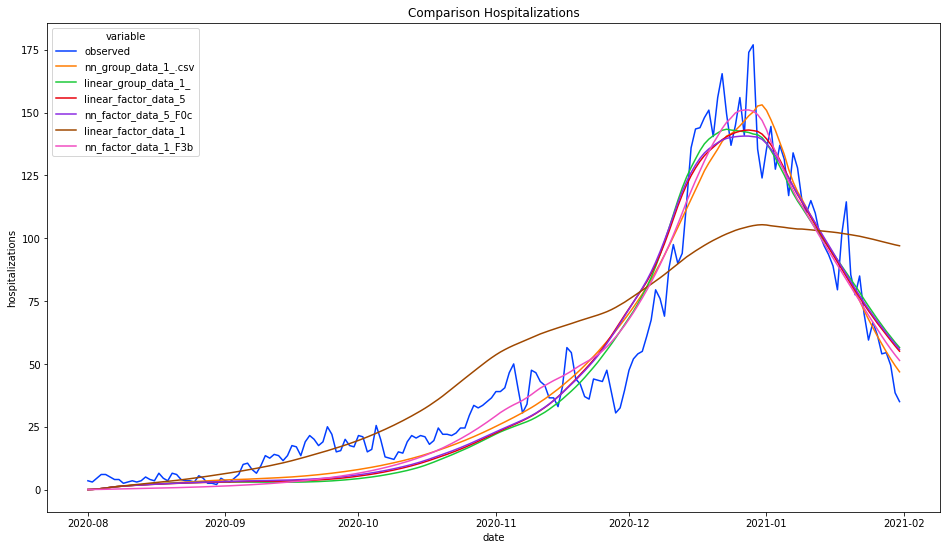

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.title('Comparison Hospitalizations')
sns.lineplot(data=df_comparison_long, x='date', y='value', hue='variable', palette='bright', ax=ax)
ax.set_ylabel('hospitalizations')
ax.set_xlabel('date')
if split:
  plt.axvline(x=pd.to_datetime(train_test_split_time, format=dt_format))
plt.show()